In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import pycrostates
import sklearn
import neurokit2

from skstab import StadionEstimator
from package1.tbd import ModKMeansSkstab, scale_data
from package1.neurokit_to_sklearn_API import NeurokitCluster
from package1.fuzzykmedoids import CFKM, FKM, FMMdd
from pycrostates.utils.utils import _distance_matrix
from neurokit2.microstates.microstates_clean import microstates_clean

In [2]:
data_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro")
file = data_folder / "sub-001_ses-t1_task-resteyesc_eeg.edf"
processed_folder = pathlib.Path(r"C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned")
processed_file = processed_folder / "sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set"

In [3]:
raw = mne.io.read_raw_edf(file, preload=True)
cleaned = mne.io.read_epochs_eeglab(processed_file)

Extracting EDF parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro\sub-001_ses-t1_task-resteyesc_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 245759  =      0.000 ...   239.999 secs...
Extracting parameters from C:\Users\Gulbr\MasterOppgave\SRM_rs_EEG_OpenNeuro_cleaned\sub-001_ses-t1_task-resteyesc_desc-epochs_eeg.set...
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
Ready.


In [38]:
print(raw.info)
print(cleaned.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2021-08-24 10:56:14 UTC
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 1 item (dict)
>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>


In [4]:
raw_highpass = raw.copy().filter(l_freq=0.5, h_freq=None) #There might be an issue with MNE highpass filtering, see "EEG is better left alone."

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


In [5]:
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 339 samples (0.331 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [6]:
raw_alpha = raw.copy().filter(8, 12, n_jobs=4, l_trans_bandwidth=1, h_trans_bandwidth=1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 3381 samples (3.302 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    7.8s finished


In [7]:
raw_alpha_down_sampled = raw_alpha.copy().resample(sfreq=256)

In [8]:
raw_down_sampled = raw_lowpass.copy().resample(sfreq=256)

In [44]:
print(raw_down_sampled.get_data().shape)

(64, 61440)


In [9]:
gfp_data = pycrostates.preprocessing.extract_gfp_peaks(raw_down_sampled, min_peak_distance=1) #Should I consider othe min distances?

In [46]:
print(gfp_data.get_data().shape)

(64, 5937)


In [10]:
gfp_data_cleaned = pycrostates.preprocessing.extract_gfp_peaks(cleaned, min_peak_distance=1)

In [24]:
data, indices, gfp, info_mne  = microstates_clean(raw_down_sampled, standardize_eeg=False)
print(indices.shape, gfp.shape, data.shape)
gfp_peakes = gfp[indices]
print(gfp_peakes.shape)
new_indices = np.argpartition(gfp_peakes, -6105)[-6105:]
print(new_indices.shape)
neuro_gfp_data = data[:, indices][:, new_indices]
print(neuro_gfp_data.shape)

(6105,) (61440,) (64, 61440)
(6105,)
(6105,)
(64, 6105)


In [17]:
gfp_alpha = pycrostates.preprocessing.extract_gfp_peaks(raw_alpha_down_sampled, min_peak_distance=1)

In [ ]:
print(gfp_data.get_data().shape)

In [ ]:
gfp_data.info

In [ ]:
##############################
#Fuzzy k-medioids
##############################
norms = scale_data(neuro_gfp_data.T, z_score=False)
activation = norms.dot(norms.T)
absolute_cosine_matrix = np.abs(activation)
np.fill_diagonal(absolute_cosine_matrix, 0)



In [ ]:
print(absolute_cosine_matrix)

[[0.         0.82572112 0.81396899 ... 0.12801281 0.1889082  0.08746056]
 [0.82572112 0.         0.80412784 ... 0.03243772 0.12266956 0.35935967]
 [0.81396899 0.80412784 0.         ... 0.20554008 0.19267017 0.19404604]
 ...
 [0.12801281 0.03243772 0.20554008 ... 0.         0.86723313 0.58161496]
 [0.1889082  0.12266956 0.19267017 ... 0.86723313 0.         0.63333433]
 [0.08746056 0.35935967 0.19404604 ... 0.58161496 0.63333433 0.        ]]


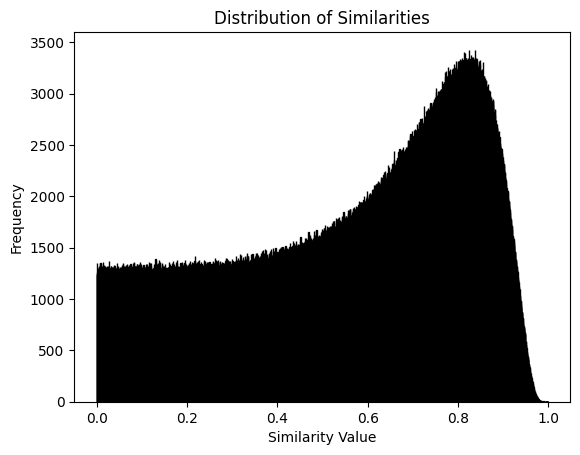

: 

In [ ]:
# Flatten the upper triangular part of the matrix (excluding the diagonal)
# This is to avoid counting self-similarities (diagonal elements)
similarities = absolute_cosine_matrix[np.triu_indices(absolute_cosine_matrix.shape[0], k=1)]

# Create a histogram
plt.hist(similarities, bins=3500, edgecolor='k')
plt.xlabel('Similarity Value')
plt.ylabel('Frequency')
plt.title('Distribution of Similarities')
plt.show()

In [ ]:
cluster_numbers = range(2, 20)
scores = {
    "Silhouette": np.zeros(len(cluster_numbers)),
    "Calinski-Harabasaz": np.zeros(len(cluster_numbers)),
    "FPC": np.zeros(len(cluster_numbers)),
    "Davies-Bouldin": np.zeros(len(cluster_numbers)),
}


In [ ]:
for k, n_clusters in enumerate(cluster_numbers):
    
    # fit K-means algorithm with a set number of cluster centers
    #ModK = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, init='k-means++', n_init= 10)
    #ModK = NeurokitCluster(method='kmod', n_microstates=n_clusters, sampling_rate=256, random_state=42)
    ModK = pycrostates.cluster.ModKMeans(n_clusters=n_clusters, random_state=42)
    
    
    #ddd = scale_data(gfp_data.get_data().T, z_score=False)
    #ddd = scale_data(neuro_gfp_data.T, z_score=False)
    #ddd = gfp_data.get_data()#.T
    ModK.fit(gfp_data)
    #scalar = sklearn.preprocessing.StandardScaler()
    #ddd = scalar.fit_transform(ddd)
    
    #cntr, u, u0, d, jm, p, fpc = skfuzzy._cluster.cmeans(ddd ,c=n_clusters, m=3, error=0.005, maxiter=1000, init=None, seed=42, metric='cosine')
    #cluster_membership = np.argmax(u, axis=0)
    #manifold = Hypersphere(dim=63)
    #ModK = RiemannianKMeans(manifold, n_clusters=n_clusters)

    #sulo = FKM(absolute_cosine_matrix, n_clusters, 2)
    #cluster_membership = np.argmax(sulo[1], axis=0)

    #sil = _distance_matrix(ddd)
    #ddd = scale_data(gfp_data_cleaned.get_data().T, z_score=False)

    #ModK.fit(ddd)
    # compute scores
    #scores["Silhouette"][k] = pycrostates.metrics.silhouette_score(ModK)
    #scores["Silhouette"][k] = sklearn.metrics.silhouette_score(sil, ModK.labels_, metric="precomputed")
    scores["Silhouette"][k] = sklearn.metrics.silhouette_score(absolute_cosine_matrix, ModK.labels_, metric="precomputed")
    #scores["Calinski-Harabasaz"][k] = sklearn.metrics.calinski_harabasz_score(ddd, ModK.labels_)
    #scores["Calinski-Harabasaz"][k] = pycrostates.metrics.calinski_harabasz_score(ModK)
    #scores["FPC"][k] = fpc
    #scores["Davies-Bouldin"][k] = sklearn.metrics.davies_bouldin_score(ddd, ModK.labels_)
    #scores["Davies-Bouldin"][k] = pycrostates.metrics.davies_bouldin_score(ModK)

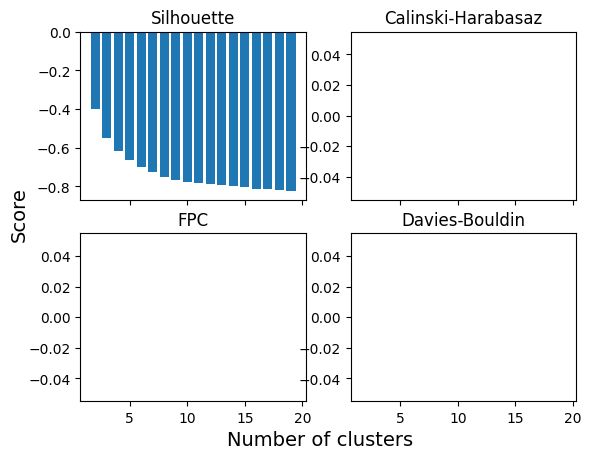

In [ ]:
f, ax = plt.subplots(2, 2, sharex=True)
for k, (score, values) in enumerate(scores.items()):
    ax[k // 2, k % 2].bar(x=cluster_numbers, height=values)
    ax[k // 2, k % 2].set_title(score)
plt.text(
    0.03, 0.5, "Score",
    horizontalalignment='center',
    verticalalignment='center',
    rotation=90,
    fontdict=dict(size=14),
    transform=f.transFigure,
)
plt.text(
    0.5, 0.03, "Number of clusters",
    horizontalalignment='center',
    verticalalignment='center',
    fontdict=dict(size=14),
    transform=f.transFigure,
)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import rand_score
import numpy as np

# Define the number of runs for stability analysis
num_runs = 10  # You can adjust this as needed

# Define the number of clusters to evaluate
n_clusters = 9  # Change this to your desired number of clusters

# Initialize an array to store cluster assignments
cluster_assignments = []

# Perform cluster stability analysis
for r in range(num_runs):
    # Create a K-means instance with a random initialization
    ModK = pycrostates.cluster.ModKMeans(n_clusters=n_clusters, random_state=r)
    
    # Fit the model to your data and get cluster assignments
    ModK.fit(gfp_data, n_jobs=4)  # Replace 'data' with your dataset
    
    # Store the cluster assignments for this run
    cluster_assignments.append(ModK.labels_)

# Calculate the Adjusted Rand Index between cluster assignments
ari_values = np.zeros((num_runs, num_runs))
for i in range(num_runs):
    for j in range(i, num_runs):
        ari = rand_score(cluster_assignments[i], cluster_assignments[j])
        ari_values[i][j] = ari
        ari_values[j][i] = ari

# Calculate the mean ARI across pairs of runs
mean_ari = np.mean(ari_values)

print(ari_values)

print(f"Mean Adjusted Rand Index between cluster assignments across {num_runs} runs: {mean_ari}")



In [ ]:
algorithm = ModKMeansSkstab

km_kwargs = {'inst': gfp_data, 'random_state': 42}

k_values = list(range(1, 21))

omega = list(range(2, 6))

dddd = scale_data(gfp_data.get_data().T)

# 4. Define stability estimation class
stab = StadionEstimator(dddd, algorithm,
                        param_name='n_clusters',
                        param_values=k_values,
                        omega=omega,
                        extended=True,
                        runs=10,
                        perturbation='uniform',
                        perturbation_kwargs='auto',
                        algo_kwargs=km_kwargs,
                        n_jobs=-1)



In [ ]:
score = stab.score(strategy='max', crossing=True)  # estimate Stadion scores

In [ ]:
k_hat = stab.select_param()  # selected number of clusters

In [ ]:
print(score, k_hat)

In [ ]:
print(ModK._fitted_data.shape)

In [ ]:
km_kwargs = {'inst': gfp_data_cleaned, 'random_state': 42}
# 4. Define stability estimation class
stab_clean = StadionEstimator(gfp_data_cleaned.get_data().T, algorithm,
                        param_name='n_clusters',
                        param_values=k_values,
                        omega=omega,
                        extended=True,
                        runs=10,
                        perturbation='uniform',
                        perturbation_kwargs='auto',
                        algo_kwargs=km_kwargs,
                        n_jobs=-1)

score_clean = stab_clean.score(strategy='max', crossing=True)  # estimate Stadion scores
k_hat_clean = stab_clean.select_param()  # selected number of clusters

In [ ]:
print(score_clean, k_hat_clean)

In [ ]:
algorithm = sklearn.cluster.KMeans

km_kwargs = {'init': 'k-means++', 'n_init': 10}

k_values = list(range(1, 21))

omega = list(range(2, 6))


data_t1 = scale_data(gfp_data.get_data().T, z_score=False)

# 4. Define stability estimation class
stab_t1 = StadionEstimator(data_t1, algorithm,
                        param_name='n_clusters',
                        param_values=k_values,
                        omega=omega,
                        extended=True,
                        runs=10,
                        perturbation='uniform',
                        perturbation_kwargs='auto',
                        algo_kwargs=km_kwargs,
                        n_jobs=-1)

score_t1 = stab_t1.score(strategy='max', crossing=True)  # estimate Stadion scores
k_hat_t1 = stab_t1.select_param()  # selected number of clusters

In [ ]:
print(score_t1) 
print(k_hat_t1)

In [ ]:
algorithm = sklearn.cluster.KMeans

km_kwargs = {'n_init': 10}

k_values = list(range(1, 21))

omega = list(range(2, 6))

data_t1_cl = scale_data(gfp_data_cleaned.get_data().T, z_score=False)

# 4. Define stability estimation class
stab_t1_cl = StadionEstimator(data_t1_cl, algorithm,
                        param_name='n_clusters',
                        param_values=k_values,
                        omega=omega,
                        extended=True,
                        runs=10,
                        perturbation='uniform',
                        perturbation_kwargs='auto',
                        algo_kwargs=km_kwargs,
                        n_jobs=-1)

score_t1_cl = stab_t1_cl.score(strategy='max', crossing=True)  # estimate Stadion scores
k_hat_t1_cl = stab_t1_cl.select_param()  # selected number of clusters

In [ ]:
print(score_t1_cl)
print(k_hat_t1_cl)

In [ ]:
import numpy as np
from skstab import ModelExplorer
from skstab.datasets import load_dataset
from sklearn.cluster import KMeans



algorithm = ModKMeansSkstab
km_kwargs = {'inst': gfp_data, 'random_state': 42}

k_values = list(range(2, 10))
print('Evaluated numbers of clusters:', k_values)

stab = ModelExplorer(gfp_data.get_data().T, algorithm,
                     param_name='n_clusters',
                     param_values=k_values,
                     f=0.8,
                     runs=100,
                     algo_kwargs=km_kwargs,
                     n_jobs=-1)

score_ME = stab.score()
print('Model explorer scores:\n', score)
k_hat_ME = stab.select_param()[0]
print('Selected number of clusters: K =', k_hat)

In [ ]:
test = ModKMeansSkstab(n_clusters=4, inst=gfp_data, random_state=42)


In [ ]:
test.fit(d=gfp_data.get_data().T)

In [ ]:
p = test.predict(gfp_data.get_data().T)

In [ ]:
print(p.shape)

In [ ]:
from skstab import StadionEstimator
from skstab.datasets import load_dataset
from sklearn.cluster import KMeans

# 1. Load data
X = gfp_data.get_data().T

# 2. Choose clustering algorithm
algorithm = KMeans
km_kwargs = {'init': 'k-means++', 'n_init': 10}  # algorithm settings

# 3. Fix range of parameters and Stadion hyperparameter omega
k_values = list(range(1, 11))  # evaluate K=1 to K=10
omega = list(range(2, 6))  # keep this fixed to 2:5 or 2:10

# 4. Define stability estimation class
stab = StadionEstimator(X, algorithm,
                        param_name='n_clusters',
                        param_values=k_values,
                        omega=omega,
                        extended=True,
                        runs=10,
                        perturbation='uniform',
                        perturbation_kwargs='auto',
                        algo_kwargs=km_kwargs,
                        n_jobs=-1)

# 5. Evaluate stability scores
score = stab.score(strategy='max', crossing=True)  # estimate Stadion scores
k_hat = stab.select_param()[0]  # selected number of clusters

In [ ]:
print(gfp_data.get_data().shape)

In [ ]:
from skstab import StadionEstimator
from skstab.datasets import load_dataset
from sklearn.cluster import KMeans
from package1.neurokit_to_sklearn_API import NeurokitCluster

# 1. Load data
X = gfp_data.get_data().T

# 2. Choose clustering algorithm
algorithm = NeurokitCluster
km_kwargs = {'sampling_rate': 256, 'random_state': 42}  # algorithm settings

# 3. Fix range of parameters and Stadion hyperparameter omega
k_values = list(range(1, 20))  # evaluate K=1 to K=10
omega = list(range(2, 6))  # keep this fixed to 2:5 or 2:10

# 4. Define stability estimation class
stab = StadionEstimator(X, algorithm,
                        param_name='n_microstates',
                        param_values=k_values,
                        omega=omega,
                        extended=True,
                        runs=10,
                        perturbation='uniform',
                        perturbation_kwargs='auto',
                        algo_kwargs=km_kwargs,
                        n_jobs=-1)

# 5. Evaluate stability scores
score = stab.score(strategy='max', crossing=True)  # estimate Stadion scores
k_hat = stab.select_param()[0]  # selected number of clusters

In [25]:
ModK = pycrostates.cluster.ModKMeans(n_clusters=5, random_state=42)
ModK.fit(gfp_data, n_jobs=4)

In [26]:
ModK.set_montage('biosemi64')

Method,ModKMeans
Fit,100 initializations on 5937 samples
Cluster centers,5
GEV,78.27 %
Cluster centers names,"0, 1, 2, 3, 4"
Channels,64 EEG


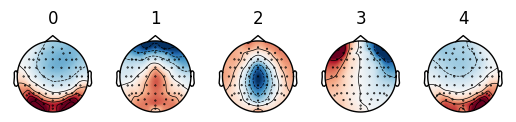

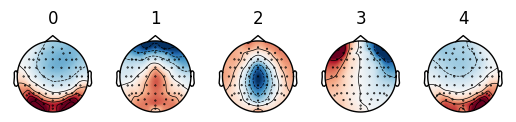

In [27]:
ModK.plot()

In [ ]:
for i in range(4):
    pycrostates.viz.plot_cluster_centers(ModK.cluster_centers_[i*4 : (i+1)*4], ModK.info)

In [ ]:
print(ModK.cluster_centers_.shape)

In [28]:
ModK_cleaned = pycrostates.cluster.ModKMeans(n_clusters=5, random_state=42)
ModK_cleaned.fit(gfp_data_cleaned, n_jobs=4)

In [29]:
ModK_cleaned.set_montage('biosemi64')

Method,ModKMeans
Fit,100 initializations on 5794 samples
Cluster centers,5
GEV,83.15 %
Cluster centers names,"0, 1, 2, 3, 4"
Channels,64 EEG


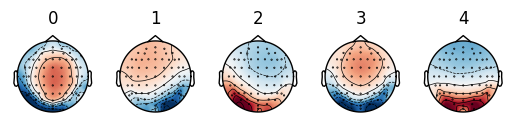

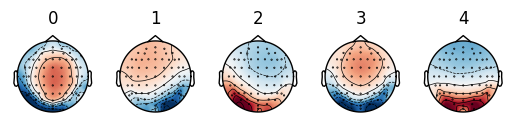

In [30]:
ModK_cleaned.plot()

In [ ]:
ModK_alpha = pycrostates.cluster.ModKMeans(n_clusters=9, random_state=42)
ModK_alpha.fit(gfp_alpha, n_jobs=4)
ModK_alpha.set_montage('biosemi64')
ModK_alpha.plot()

In [ ]:
inf = ModK_alpha.info

In [ ]:
from neurokit2.microstates.microstates_segment import microstates_segment
neurokitter = microstates_segment(raw_down_sampled, 4)

In [ ]:
print(neurokitter['Microstates'])

In [ ]:
from pycrostates.viz.cluster_centers import plot_cluster_centers

manifold = Hypersphere(dim=63)
ModK = RiemannianKMeans(manifold, n_clusters=4)
ModK.fit(ddd)
"""plottcla = pycrostates.cluster.ModKMeans(n_clusters=5)
plottcla._fitted = True
plottcla._labels_ = ModK.labels_
plottcla._cluster_centers_ = ModK.centroids_
plottcla._info = 1
plottcla._fitted_data = ddd
plottcla._GEV_ = 0.9"""
plot_cluster_centers(ModK.centroids_, inf)
